In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import plot_tree
import statsmodels.api as sm
from pandasgui import show
from xgboost import XGBClassifier, plot_importance
import shap

In [2]:
heart_df = pd.read_csv("c:/Users/gary1/Documents/DSSA/Final/heart.csv")
heart_attack_df = pd.read_csv("c:/Users/gary1/Documents/DSSA/Final/Medicaldataset.csv")

In [3]:
X = heart_df.drop("HeartDisease", axis = 1)
y = heart_df["HeartDisease"]

In [4]:
categorical_cols = X.select_dtypes(include ="object").columns.tolist()
numeric_cols = X.select_dtypes(include = ["int64", "float64"]).columns.tolist()

In [5]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop="first", sparse_output = False)

In [6]:
preprocessor = ColumnTransformer(
    transformers = [
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

In [7]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [8]:
X_train_processed = preprocessor.fit_transform(X_train_raw)
X_test_processed = preprocessor.transform(X_test_raw)

In [9]:
model_plain = LogisticRegression()
model_plain.fit(X_train_processed, y_train)
y_pred_plain = model_plain.predict(X_test_processed)

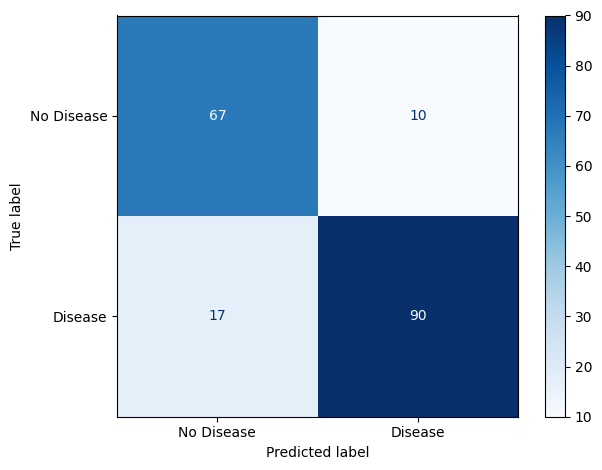

Sensitivity (no PCA): 0.841
Specificity (no PCA): 0.870


In [12]:
cm_plain = confusion_matrix(y_test, y_pred_plain)
tn, fp, fn, tp = cm_plain.ravel()

disp_plain = ConfusionMatrixDisplay(confusion_matrix=cm_plain, display_labels=["No Disease", "Disease"])
disp_plain.plot(cmap="Blues")
plt.tight_layout()
plt.show()

sensitivity_plain = tp / (tp + fn)
specificity_plain = tn / (tn + fp)

print(f"Sensitivity (no PCA): {sensitivity_plain:.3f}")
print(f"Specificity (no PCA): {specificity_plain:.3f}")

In [15]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_processed)
X_test_pca = pca.transform(X_test_processed)


In [16]:
model_pca = LogisticRegression()
model_pca.fit(X_train_pca, y_train)
y_pred_pca = model_pca.predict(X_test_pca)

In [17]:
cm_pca = confusion_matrix(y_test, y_pred_pca)
report_pca = classification_report(y_test, y_pred_pca, output_dict=True)
acc_pca = accuracy_score(y_test, y_pred_pca)

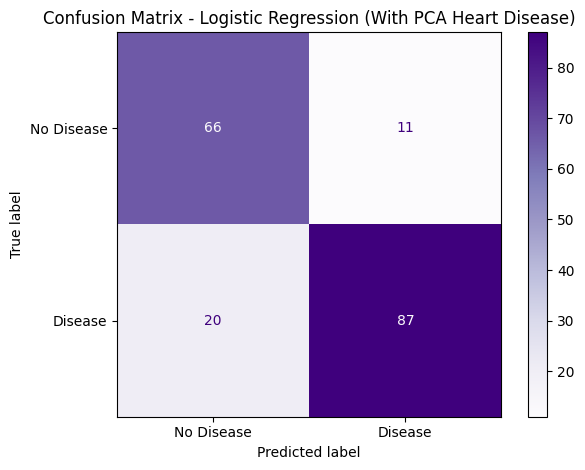

Sensitivity (With PCA): 0.813
Specificity (With PCA): 0.857


In [18]:
tn, fp, fn, tp = cm_pca.ravel()

disp_pca = ConfusionMatrixDisplay(confusion_matrix=cm_pca, display_labels=["No Disease", "Disease"])
disp_pca.plot(cmap="Purples")
plt.title("Confusion Matrix - Logistic Regression (With PCA Heart Disease)")
plt.tight_layout()
plt.show()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity (With PCA): {sensitivity:.3f}")
print(f"Specificity (With PCA): {specificity:.3f}")

In [19]:
report = classification_report(y_test, y_pred_pca, output_dict=True)
report_1 = classification_report(y_test, y_pred_plain, output_dict=True)
acc_plain =  accuracy_score(y_test, y_pred_plain)

In [20]:
print(f"Sensitivity (With PCA): {sensitivity:.3f}")
print(f"Specificity (With PCA): {specificity:.3f}")
print(f"Accuracy (With PCA): {acc_pca:.3f}")
print(f"F1-Score (With PCA): {report["1"]["f1-score"]:.3f}")
print(f"Sensitivity (Without PCA): {sensitivity_plain:.3f}")
print(f"Specificity (Without PCA): {specificity_plain:.3f}")
print(f"Accuracy (Without PCA): {acc_pca:.3f}")
print(f"F1-Score (Without PCA): {report_1["1"]["f1-score"]:.3f}")

Sensitivity (With PCA): 0.813
Specificity (With PCA): 0.857
Accuracy (With PCA): 0.832
F1-Score (With PCA): 0.849
Sensitivity (Without PCA): 0.841
Specificity (Without PCA): 0.870
Accuracy (Without PCA): 0.832
F1-Score (Without PCA): 0.870


In [21]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_processed, y_train)

RandomForestClassifier(random_state=42)

In [22]:
y_pred_rf = rf_model.predict(X_test_processed)


In [23]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
f1_rf = report_rf["1"]["f1-score"]


In [24]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
tn, fp, fn, tp = cm_rf.ravel()
sensitivity_rf = tp / (tp + fn)
specificity_rf = tn / (tn + fp)

In [25]:
print("Random Forest Evaluation (Heart Disease)")
print("-" * 40)
print(f"Accuracy: {accuracy_rf:.3f}")
print(f"F1-Score: {f1_rf:.3f}")
print(f"Sensitivity: {sensitivity_rf:.3f}")
print(f"Specificity: {specificity_rf:.3f}")

Random Forest Evaluation (Heart Disease)
----------------------------------------
Accuracy: 0.875
F1-Score: 0.892
Sensitivity: 0.888
Specificity: 0.857


In [26]:
numeric_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
ohe_feature_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
final_feature_names = numeric_features + ohe_feature_names

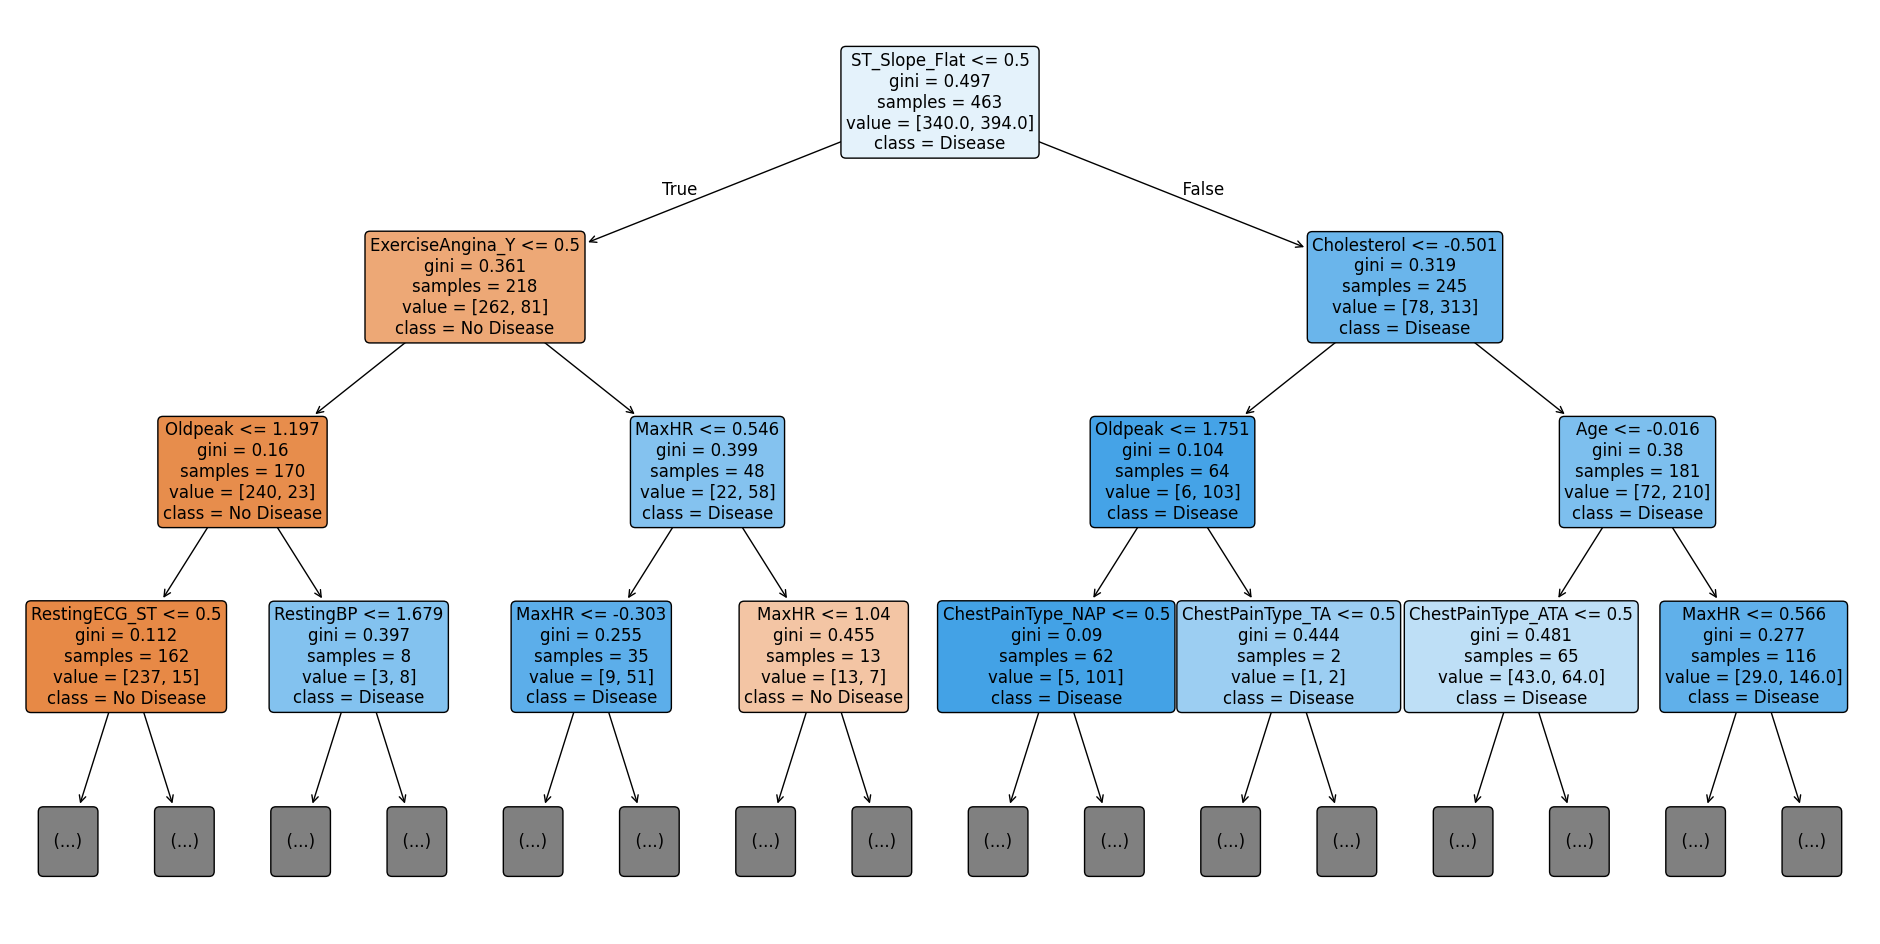

In [28]:
estimator = rf_model.estimators_[0]

plt.figure(figsize=(24, 12))
plot_tree(estimator,
          feature_names=final_feature_names,
          class_names=["No Disease", "Disease"],
          filled=True,
          rounded=True,
          max_depth=3,
          fontsize=12)
plt.show()

In [29]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_processed, y_train)

c:\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:13:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [30]:
y_pred_xgb = xgb_model.predict(X_test_processed)


In [31]:
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85        77
           1       0.90      0.88      0.89       107

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184



In [32]:
cm_xg = confusion_matrix(y_test, y_pred_xgb)
tn, fp, fn, tp = cm_xg.ravel()

specificity_xgb = tn / (tn + fp)
print(f"XGBoost Specificity: {specificity_xgb:.3f}")

XGBoost Specificity: 0.857


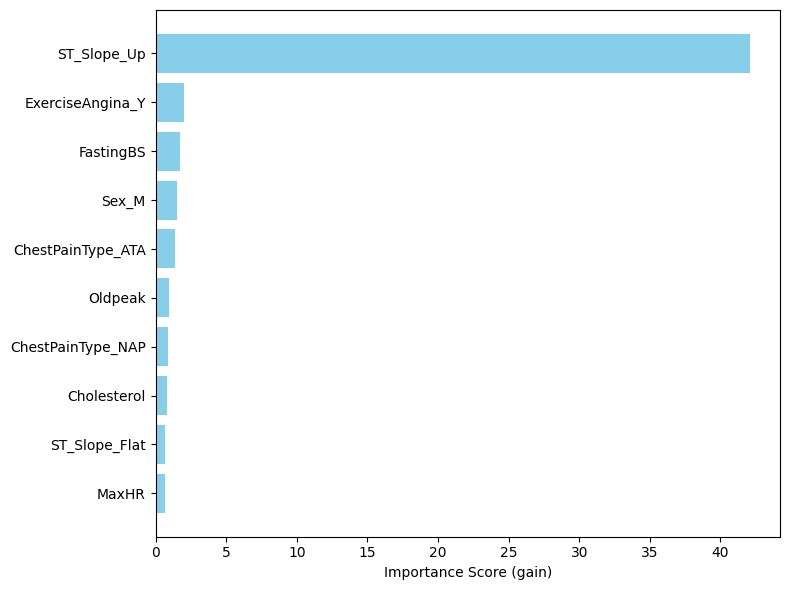

In [34]:
importance_scores = xgb_model.get_booster().get_score(importance_type='gain')

importance_df = pd.DataFrame({
    'Feature': [final_feature_names[int(k[1:])] for k in importance_scores.keys()],
    'Importance': list(importance_scores.values())
})

importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score (gain)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [35]:
explainer = shap.Explainer(xgb_model, X_train_processed, feature_names=final_feature_names)
shap_values = explainer(X_test_processed)

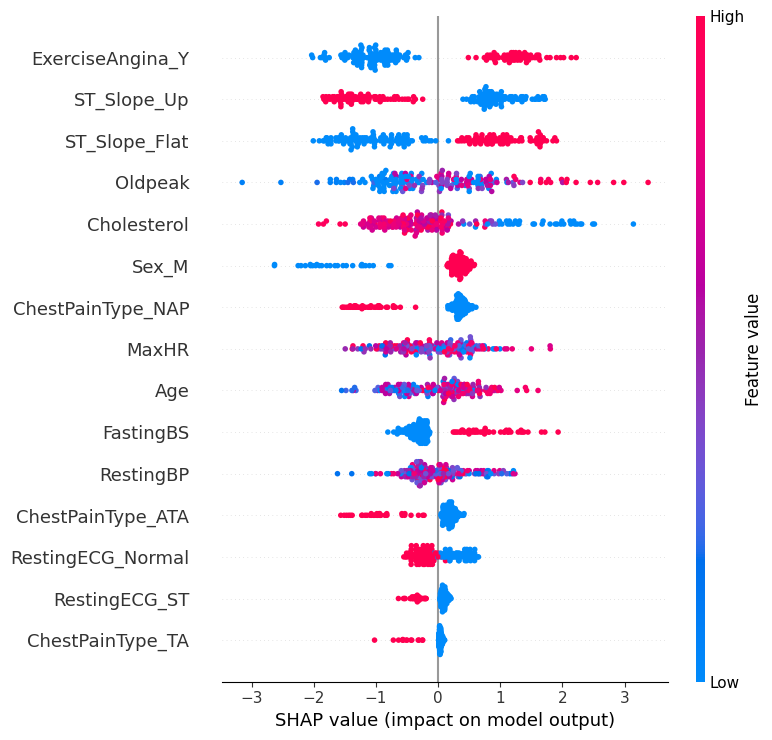

In [36]:
shap.summary_plot(shap_values, X_test_processed, feature_names=final_feature_names)

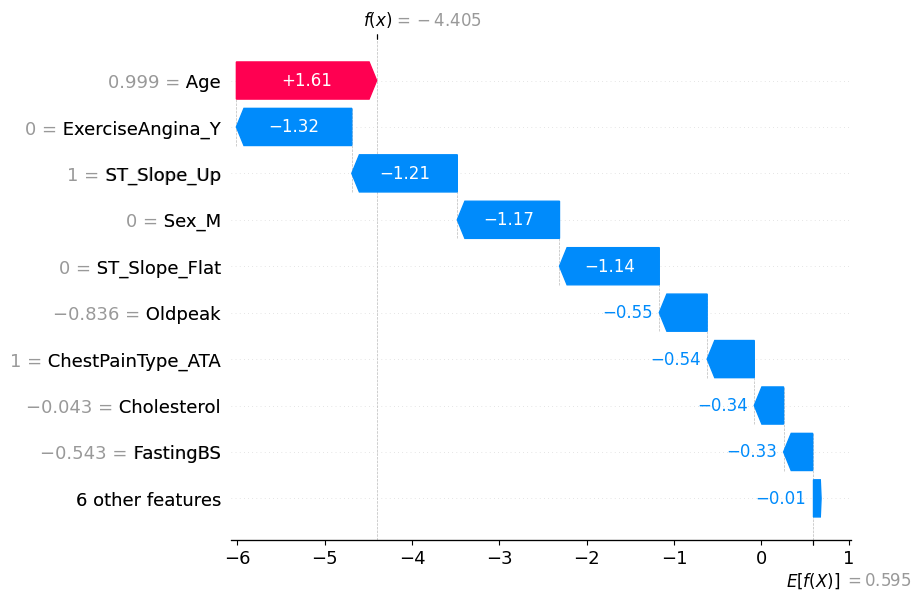

In [37]:
i = 0
shap.plots.waterfall(shap_values[i])

In [38]:
base_learners = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
]

meta_model = LogisticRegression()

stacked_model = StackingClassifier(estimators=base_learners, final_estimator=meta_model, cv=5)

c:\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:13:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:13:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Stacked Ensemble Accuracy: 0.8695652173913043

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85        77
           1       0.90      0.88      0.89       107

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184



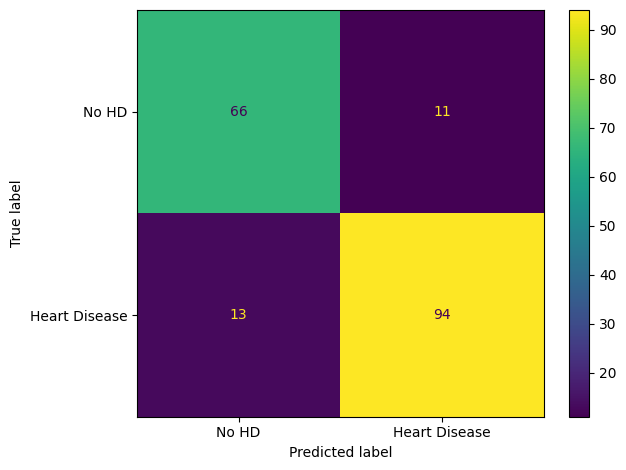

In [40]:
stacked_model.fit(X_train_processed, y_train)

y_pred_stack = stacked_model.predict(X_test_processed)

print("Stacked Ensemble Accuracy:", accuracy_score(y_test, y_pred_stack))
print("\nClassification Report:\n", classification_report(y_test, y_pred_stack))

ConfusionMatrixDisplay.from_estimator(stacked_model, X_test_processed, y_test, display_labels=["No HD", "Heart Disease"])
plt.tight_layout()
plt.show()

In [41]:
cm_stack = confusion_matrix(y_test, y_pred_stack)
tn, fp, fn, tp = cm_stack.ravel()

specificity_stack = tn / (tn + fp)
print(f"Stacked Ensemble Specificity: {specificity_stack:.3f}")

Stacked Ensemble Specificity: 0.857


Second Dataset

In [42]:
x2 = heart_attack_df.drop('Result', axis = 1)
y2 = heart_attack_df['Result'].map({'negative': 0, 'positive': 1}).astype(int)

In [43]:
x2['Gender'] = x2['Gender'].map({0: 'Female', 1: 'Male'}).astype(object)

In [44]:
categorical_cols2 = x2.select_dtypes(include = 'object').columns.tolist()
numeric_cols2 = x2.select_dtypes(include = ['int64', 'float64']).columns.tolist()

In [45]:
preprocessor2 = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols2),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols2)
    ]
)

In [46]:
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.2, random_state=42, stratify=y2)

In [47]:
x2_train_processed = preprocessor2.fit_transform(x2_train)
x2_test_processed = preprocessor2.transform(x2_test)

In [48]:
model_plain2 = LogisticRegression()
model_plain2.fit(x2_train_processed, y2_train)
y_pred_plain2 = model_plain2.predict(x2_test_processed)

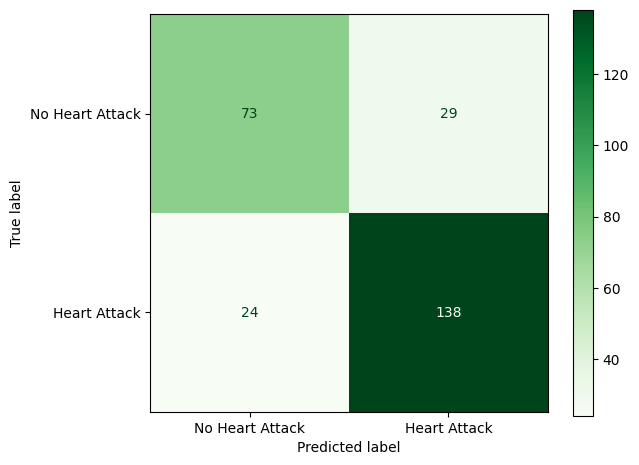

Sensitivity: 0.852
Specificity: 0.716
Accuracy: 0.799
F1 Score: 0.839


In [49]:
cm_plain2 = confusion_matrix(y2_test, y_pred_plain2)
tn, fp, fn, tp = cm_plain2.ravel()

disp_plain2 = ConfusionMatrixDisplay(confusion_matrix=cm_plain2, display_labels=["No Heart Attack", "Heart Attack"])
disp_plain2.plot(cmap="Greens")
plt.tight_layout()
plt.show()

sensitivity_plain2 = tp / (tp + fn)
specificity_plain2 = tn / (tn + fp)
accuracy_plain2 = accuracy_score(y2_test, y_pred_plain2)
f1_plain2 = f1_score(y2_test, y_pred_plain2)

print(f"Sensitivity: {sensitivity_plain2:.3f}")
print(f"Specificity: {specificity_plain2:.3f}")
print(f"Accuracy: {accuracy_plain2:.3f}")
print(f"F1 Score: {f1_plain2:.3f}")

less than 10 features so I will not use PCA

In [50]:
rf_model2 = RandomForestClassifier(random_state = 42)
rf_model2.fit(x2_train_processed, y2_train)

RandomForestClassifier(random_state=42)

In [51]:
y_pred_rf2 = rf_model2.predict(x2_test_processed)

In [52]:
accuracy_rf2 = accuracy_score(y2_test, y_pred_rf2)
report_rf2 = classification_report(y2_test, y_pred_rf2, output_dict=True)
f1_rf2 = report_rf2['1']['f1-score']


In [53]:
cm_rf2 = confusion_matrix(y2_test, y_pred_rf2)
tn, fp, fn, tp = cm_rf2.ravel()
sensitivity_rf2 = tp / (tp + fn)
specificity_rf2 = tn / (tn + fp)

In [54]:
print("Random Forest Evaluation (Heart Attack)")
print("-" * 40)
print(f"Accuracy: {accuracy_rf2:.3f}")
print(f"F1-Score: {f1_rf2:.3f}")
print(f"Sensitivity: {sensitivity_rf2:.3f}")
print(f"Specificity: {specificity_rf2:.3f}")

Random Forest Evaluation (Heart Attack)
----------------------------------------
Accuracy: 0.985
F1-Score: 0.988
Sensitivity: 0.988
Specificity: 0.980


In [55]:
numeric_features2 = ['Age', 'Heart Rate', 'Systolic blood pressure', 'Diastolic blood pressure', 'Blood sugar', 'CK-MB', 'Troponin']
categorical_features2 = ['Gender']
ohe_feature_names2 = list(preprocessor2.named_transformers_['cat'].get_feature_names_out(categorical_features2))
final_feature_names2 = numeric_features2 + ohe_feature_names2

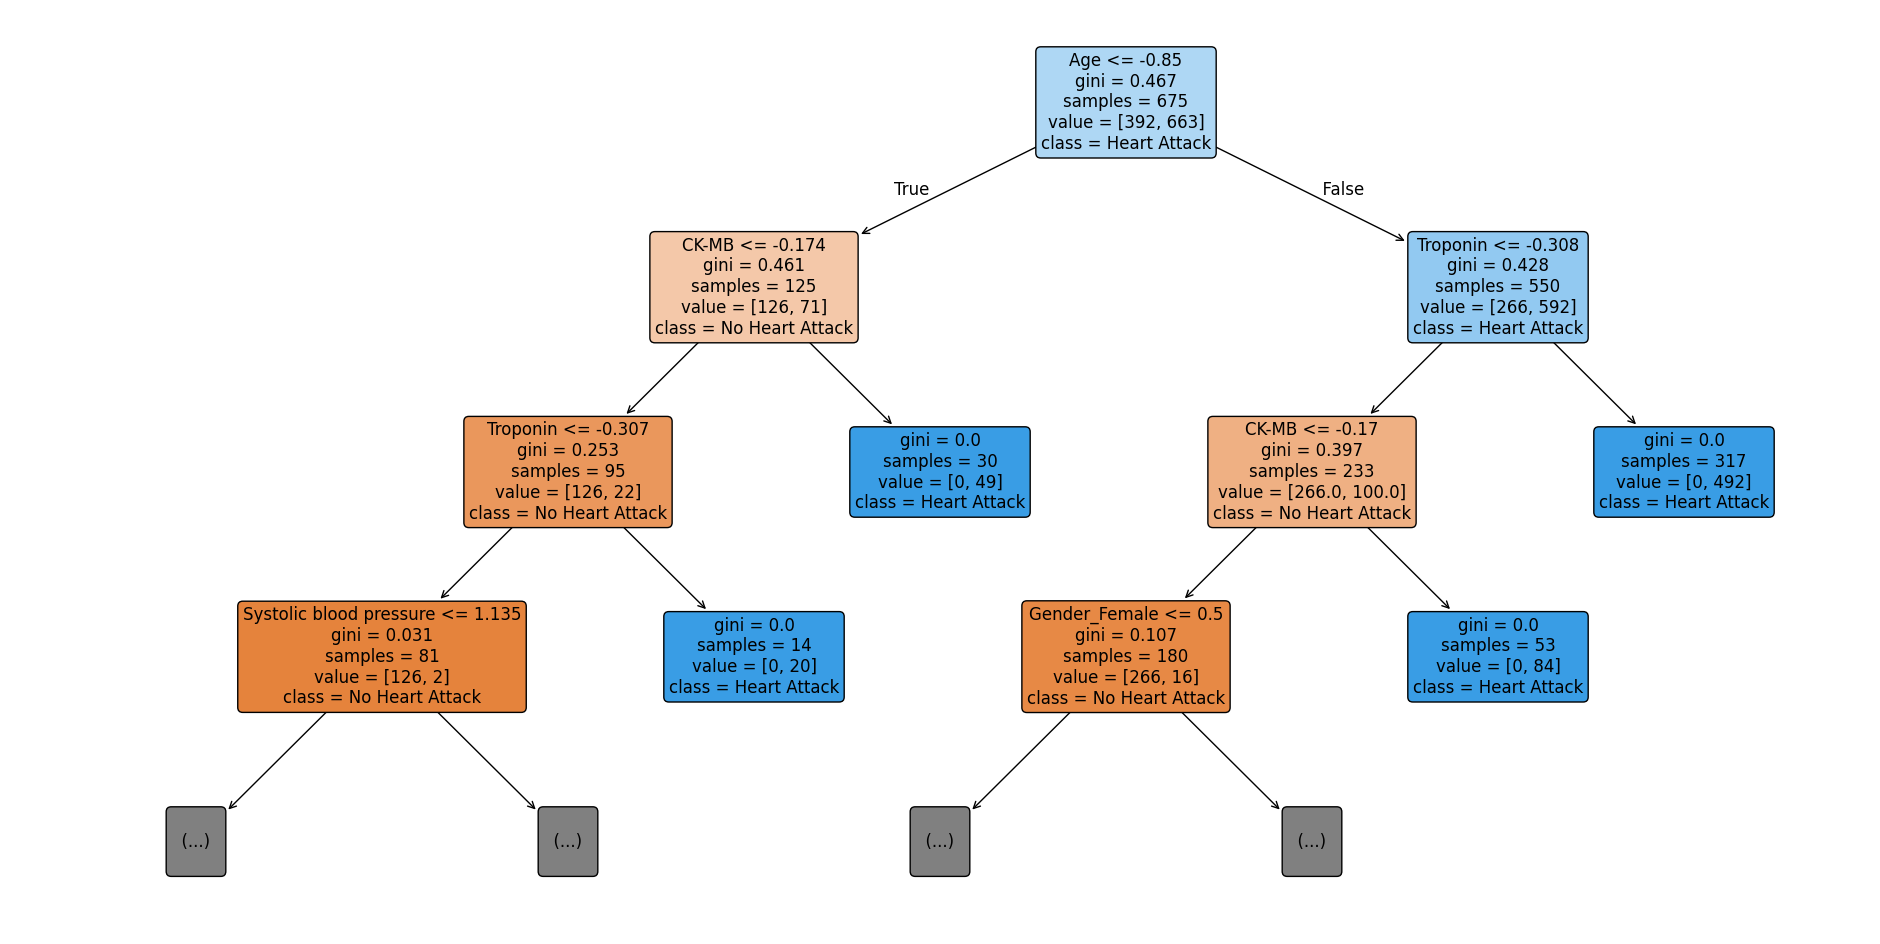

In [57]:
estimator2 = rf_model2.estimators_[0]

plt.figure(figsize=(24, 12))
plot_tree(estimator2,
          feature_names=final_feature_names2,
          class_names=["No Heart Attack", "Heart Attack"],
          filled=True,
          rounded=True,
          max_depth=3,
          fontsize=12)
plt.show()

In [58]:
xgb_model2 = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss')
xgb_model2.fit(x2_train_processed, y2_train)

c:\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:14:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [59]:
y_pred_xgb2 = xgb_model2.predict(x2_test_processed)

In [60]:
print("Classification Report:\n", classification_report(y2_test, y_pred_xgb2, digits = 3))

Classification Report:
               precision    recall  f1-score   support

           0      0.980     0.980     0.980       102
           1      0.988     0.988     0.988       162

    accuracy                          0.985       264
   macro avg      0.984     0.984     0.984       264
weighted avg      0.985     0.985     0.985       264



In [61]:
cm_xg2 = confusion_matrix(y2_test, y_pred_xgb2)
tn, fp, fn, tp = cm_xg2.ravel()

specificity_xgb2 = tn / (tn + fp)
print(f"XGBoost Specificity: {specificity_xgb2:.3f}")

XGBoost Specificity: 0.980


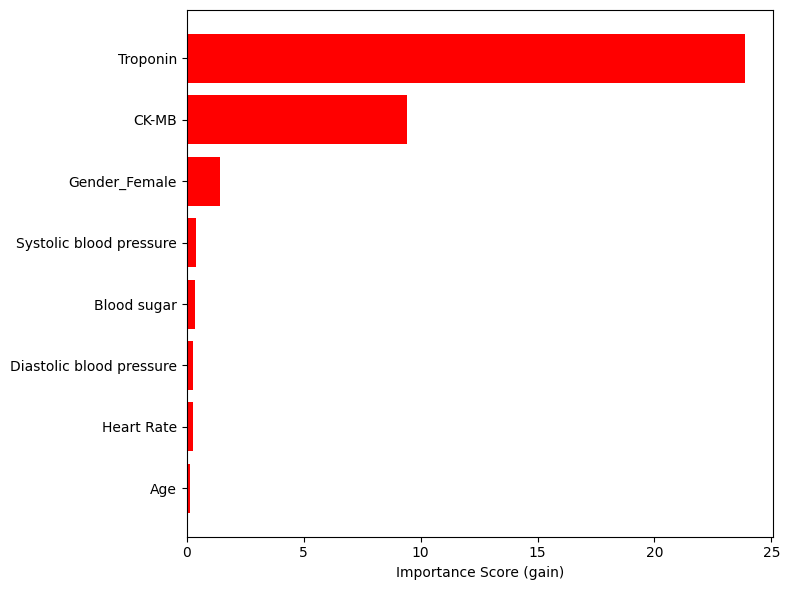

In [63]:
importance_scores2 = xgb_model2.get_booster().get_score(importance_type='gain')

importance_df2 = pd.DataFrame({
    'Feature': [final_feature_names2[int(k[1:])] for k in importance_scores2.keys()],
    'Importance': list(importance_scores2.values())
})

importance_df2 = importance_df2.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(8, 6))
plt.barh(importance_df2['Feature'], importance_df2['Importance'], color='red')
plt.xlabel('Importance Score (gain)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [64]:
explainer2 = shap.Explainer(xgb_model2, x2_train_processed, feature_names=final_feature_names2)
shap_values2 = explainer2(x2_test_processed)

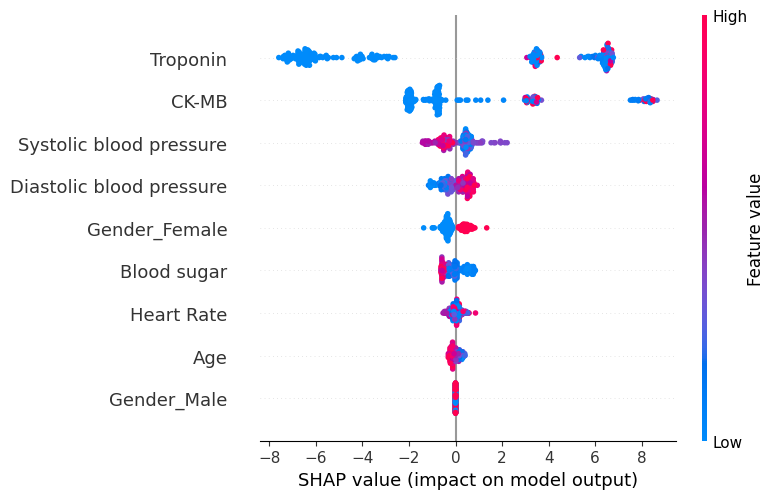

In [65]:
shap.summary_plot(shap_values2, x2_test_processed, feature_names=final_feature_names2)

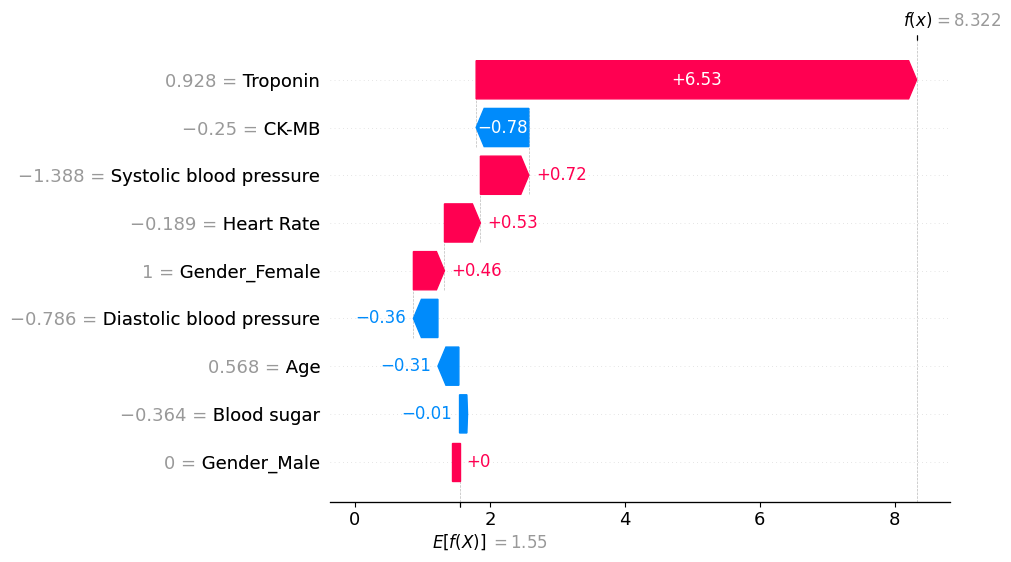

In [66]:
i = 0
shap.plots.waterfall(shap_values2[i])

stacked ensemble not useful when XGBoost and Random Forest performed well

In [67]:
timeseries_hd = pd.read_csv("c:/Users/gary1/Documents/DSSA/Final/timeserieshd.csv")

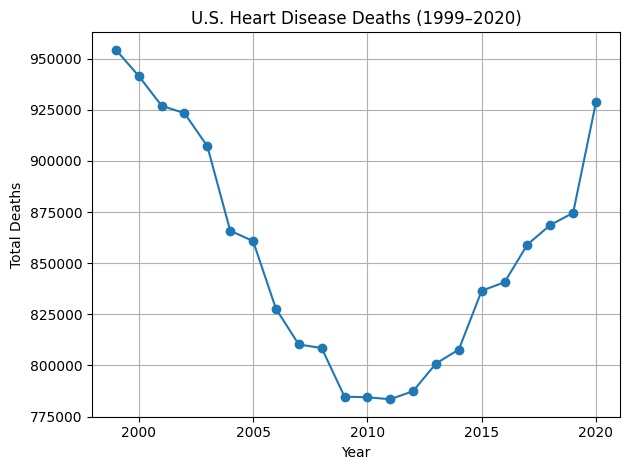

In [68]:
plt.plot(timeseries_hd["Year"], timeseries_hd["Deaths"], marker='o')
plt.title("U.S. Heart Disease Deaths (1999–2020)")
plt.xlabel("Year")
plt.ylabel("Total Deaths")
plt.grid(True)
plt.tight_layout()
plt.show()